In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

In [108]:
import pandas as pd
df = pd.read_csv("absorbance.csv")

In [109]:
wba_df = df.iloc[:,39:]
batch_size = 32
train_data = torch.tensor(wba_df.values, dtype=torch.float32)
train_data

tensor([[0.0987, 0.1274, 0.1592,  ..., 0.2530, 0.2282, 0.2003],
        [0.1114, 0.1501, 0.1860,  ..., 0.2048, 0.1917, 0.1659],
        [0.1096, 0.1509, 0.1941,  ..., 0.3237, 0.3056, 0.2881],
        ...,
        [0.1016, 0.1186, 0.1060,  ..., 0.3136, 0.2871, 0.2679],
        [0.0366, 0.0414, 0.0577,  ..., 0.0612, 0.0427, 0.0031],
        [0.0267, 0.0294, 0.0424,  ..., 0.4081, 0.3874, 0.3852]])

In [110]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)

In [111]:
# define a simple linear VAE
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
        self.wba_input_size = 107
        self.latent_dim = 10
 
        # encoder
        self.enc1 = nn.Linear(in_features=self.wba_input_size, out_features=self.wba_input_size//2)
        self.enc2 = nn.Linear(in_features=self.wba_input_size//2, out_features=self.latent_dim*2)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=self.latent_dim, out_features=self.wba_input_size//2)
        self.dec2 = nn.Linear(in_features=self.wba_input_size//2, out_features=self.wba_input_size)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def encode(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = self.enc2(x).view(-1, 2, self.latent_dim)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        return mu, log_var

    def decode(self, z):
        x = F.relu(self.dec1(z))
        reconstruction = torch.sigmoid(self.dec2(x))
        return reconstruction

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decode(z)
        return reconstruction, mu, log_var
    
    def sample(self, num_samples, current_device):
        z = torch.randn(num_samples, self.latent_dim)
        z = z.to(current_device)
        samples = self.decode(z)
        return samples

    def generate(self, x):
        return self.forward(x)[0]

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LinearVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.BCELoss(reduction='sum')

In [113]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss 
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [114]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data = data.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [115]:
epochs = 1000
for epoch in range(epochs):
    # print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    # print(f"Train Loss: {train_epoch_loss:.4f}")

8it [00:00, 877.42it/s]              
8it [00:00, 1037.78it/s]             
8it [00:00, 503.87it/s]              
8it [00:00, 813.42it/s]              
8it [00:00, 1026.35it/s]             
8it [00:00, 1140.38it/s]             
8it [00:00, 1064.75it/s]             
8it [00:00, 1005.98it/s]             
8it [00:00, 1023.66it/s]             
8it [00:00, 1149.99it/s]             
8it [00:00, 1033.02it/s]             
8it [00:00, 1159.21it/s]             
8it [00:00, 978.66it/s]              
8it [00:00, 1208.17it/s]             
8it [00:00, 1034.00it/s]             
8it [00:00, 1210.83it/s]             
8it [00:00, 1135.21it/s]             
8it [00:00, 1189.66it/s]             
8it [00:00, 1229.33it/s]             
8it [00:00, 1078.12it/s]             
8it [00:00, 1160.65it/s]             
8it [00:00, 1019.52it/s]             
8it [00:00, 1159.33it/s]             
8it [00:00, 1008.55it/s]             
8it [00:00, 1178.55it/s]             
8it [00:00, 991.68it/s]              
8it [00:00, 

<AxesSubplot:xlabel='variable', ylabel='value'>

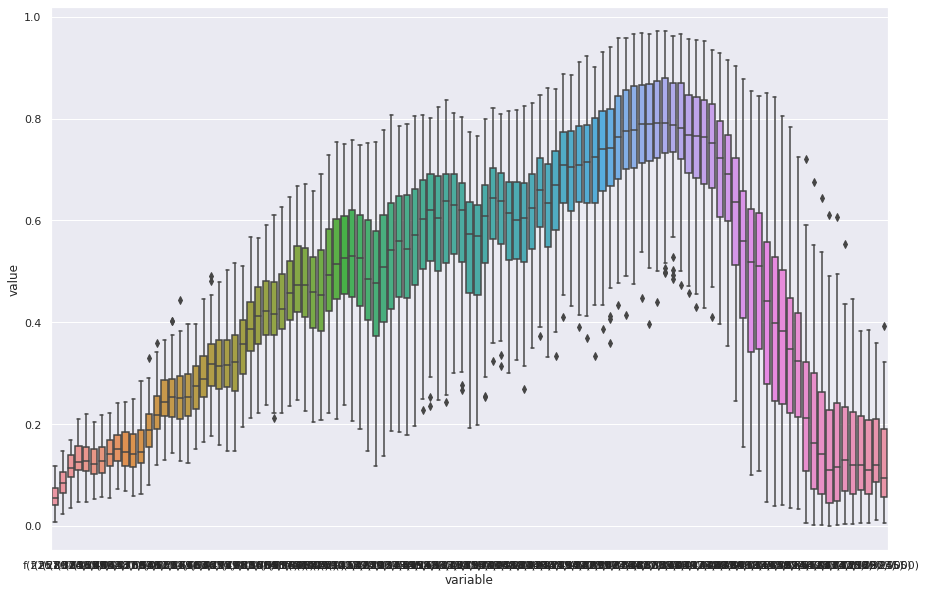

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(15,10)})
generated_samples = model.sample(100, device)
generated_samples = generated_samples.cpu().detach()
generated_df = pd.DataFrame(generated_samples, columns=df.iloc[:,39:].columns)
wba_df_scatter = generated_df.melt()
sns.boxplot(x="variable", y="value", data=wba_df_scatter)